In [1]:
import tabula
import pdfplumber
import pandas as pd
import nltk
from nltk import word_tokenize
import re
from gensim.parsing.preprocessing import remove_stopwords
from service import Service
import docx

### Reading Tables from service catalogues

In [2]:
pdf = pdfplumber.open(r"Service Catalogues\SQ15-000107_A (4).pdf")
pdf

In [3]:
def extract_all_tables(pdf):
    
    dictionary_of_tables = {} 
    for i in range(len(pdf.pages)):
        page = pdf.pages[i]
        for table in page.extract_tables():
            dictionary_of_tables['table'+str(i)] = pd.DataFrame(table[1:],columns=table[0],index=None)
    
    return dictionary_of_tables

In [46]:
dictionary_of_tables = extract_all_tables(pdf)
dictionary_of_tables

{'table4':                                              Service  \
 0  Australian \nGovernment \nDisaster Recovery \n...   
 1             Business Continuity \nPlan Development   
 2                      Business Continuity \nTesting   
 3                      Business Criticality \nReview   
 4               Business Impact \nAnalysis workshops   
 5                Monitoring \nbusiness \ndisruptions   
 6                                            Whispir   
 
                                          Description  \
 0  Represent partner departments on or provide as...   
 1  Provide assistance to customers to develop bus...   
 2  Develop and facilitate business continuity sce...   
 3  Review of critical activities by assessing the...   
 4  Conduct workshops to identify critical busines...   
 5  Provides a central point for the coordination ...   
 6  Whispir is an online communications tool utili...   
 
                         Service Level  
 0            As agreed with cust

### Removing irrelevant symbols and words from the postconditions

In [31]:
def filtering(string):
    
    string = string.replace('\n','')
    string = string.replace(' ','  ')
    string = re.sub('[^a-zA-Z ]+', '', string)
    #string = remove_stopwords(string) 
    #print(string)
    
    return string

### Extracting all the services and subsequent post conditions from the tables

In [5]:
def get_services(dictionary_of_tables):
    
    list_of_services = []
    for i in list(dictionary_of_tables.keys()):
        df = dictionary_of_tables[i]
        for index,row in df.iterrows():
            list_of_services.append(Service(str(row['Service']),filtering(str(row['Description']))))
    
    return list_of_services

In [49]:
list_of_services = get_services(dictionary_of_tables)
list_of_services

### Reading the goal statements

In [6]:
doc = docx.Document(r"Service Catalogues\Government-Goals.docx")
list_of_goals = [i.text for i in doc.paragraphs]
list_of_goals

['Equip our people and Australian businesses with the skills necessary to deliver world-leading digital services.',
 'Adopt better ways of working that bring people together quickly and efficiently and reduce risk.',
 'Collaborate with other sectors, including small and medium-sized enterprises, community organisations and academia.',
 'Develop sustainable platforms that we can share across government.',
 'Deliver value for people and businesses by managing costs and risks.',
 'Services will be smart and adapt to the data you choose to share.',
 'Policy and services will draw on data and analytics.',
 'Advanced technologies will improve decision-making and be transparent and auditable.',
 'Earn your trust through being strong custodians of your data.',
 'Customers will be able to access all government services digitally.',
 'Customers will have seamlessly integrated services that support your needs and life events.',
 'Customers will be able to choose a secure and easy to use digital i

### Loading the Transformers

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch 
import pandas as pd
import numpy as np
import sent2vec

In [8]:
labels = ['Contradiction','Neutral','Entailment']
tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
#print(len(tokenizer))
model_rob = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def roberta_probability(sentence1,sentence2):
    
    #print(sentence1,sentence2)
    id1 = tokenizer.encode(sentence1,sentence2, padding = True, max_length=512, truncation='longest_first', return_tensors="pt")
    

    
    
    logits = model_rob.forward(id1, return_dict=True).logits

    p = torch.nn.functional.softmax(logits, dim=1)
    probs = p.tolist()[0]
    labels = ['Contradiction','Neutral','Entailment']
    
    result = {}
    for keys,values in zip(labels,probs):
        result[keys] = values
    
    result['Contradiction'] = result['Contradiction']*100
    result['Neutral'] = result['Neutral']*100
    result['Entailment']= result['Entailment']*100
    
    
    
    return result

### Semantic Similarity

In [10]:
#from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
sbert_model = hub.load(module_url)
print ("module %s loaded" % module_url)

INFO:absl:Using C:\Users\indva\AppData\Local\Temp\tfhub_modules to cache modules.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [55]:
sentences = [i.description for i in list_of_services]

In [11]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [57]:
#sbert_model = SentenceTransformer('roberta-base-nli-mean-tokens')

In [58]:
sentence_embeddings = sbert_model(sentences)
len(sentence_embeddings)

280

In [12]:
def create_query_vecs(goals):
    
    query_vecs = []
    
    for i in goals:
        query_vecs.append(sbert_model([i])[0])
    
    return query_vecs

In [60]:
query_vecs = create_query_vecs(list_of_goals)
len(query_vecs)

13

In [13]:
def create_similarity_dict(query_vecs,sentences):
    
    similarity_dict = {}
    index = 0
    for i in query_vecs:
        similarity_dict['Goal'+str(index)] = []
        index+=1
        for j in sentences:
            similarity_dict['Goal'+str(index-1)].append(cosine(i, sbert_model([j])[0]))

    return similarity_dict

In [62]:
similarity_dict = create_similarity_dict(query_vecs,sentences)

In [14]:
def get_topN_similarity(similarity_dict,N):
    top_similarity = {}
    for (key,value) in similarity_dict.items():
        servkey = (sorted(range(len(value)), key=lambda i:value[i])[:-N-1:-1])
        valsim = sorted(value)[:-N-1:-1]
        top_similarity[key] = [(i,j) for (i,j) in zip(servkey,valsim)]
        
    return top_similarity

goals_service_sim = get_topN_similarity(similarity_dict,10)
#goals_service_sim

In [15]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=0.6)
    g = sns.heatmap(corr,
                    xticklabels=labels,
                    yticklabels=labels,
                    vmin=0,
                    vmax=1,
                    cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_,labels):
    message_embeddings_ = sbert_model(messages_)
    plot_similarity(labels, message_embeddings_, 90)

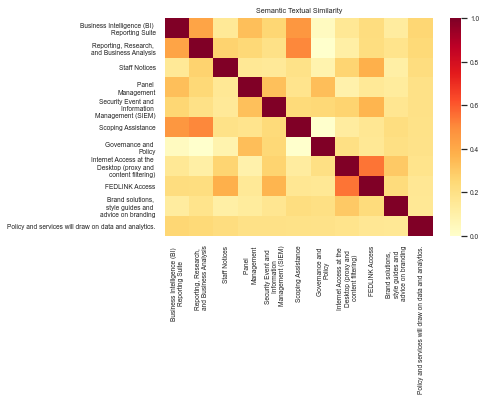

In [79]:
messages = [list_of_services[i[0]].description for i in goals_service_sim['Goal6']] + [list_of_goals[6]]
labels = [list_of_services[i[0]].name for i in goals_service_sim['Goal6']] + [list_of_goals[6]]
run_and_plot(messages,labels)

### Getting all combinations of postconditions

In [16]:
from itertools import combinations

def postcondition_generator(similar_services,list_of_services,selection):
    
    combs = list(combinations(similar_services, selection))
    
    postconds = []
    
    for comb in combs:
        postcond = str()
        services = []
        for index in comb:
            postcond += list_of_services[index[0]].description
            postcond += '. '
       
        postconds.append(postcond)
       
            
    
    return postconds,combs

In [17]:
from operator import itemgetter

In [82]:
#postconds,combs = postcondition_generator(goals_service_sim['Goal0'],list_of_services,selection=5)
#len(postconds)

### All Combinations alignment(New)

In [18]:
from tqdm import tqdm
def check_entailment(goal,list_of_postconds):
    
    
    
    result = roberta_probability(list_of_postconds[0],goal)
    
    pbar = tqdm(total = len(list_of_postconds),position=0, leave=True) 
    
    runs=1
    
    while (result['Entailment'] < 66 and runs <= len(list_of_postconds)):
        
        try:
            newresult = roberta_probability(list_of_postconds[runs],goal)
            
            if newresult['Entailment'] > result['Entailment']:
                result,runs = newresult,runs
            
            pbar.update(1)
            runs+=1
            
        except IndexError as error:
            print("Benchmark probability not reached")
            break
            
    pbar.close()
            
    return result,runs

In [19]:
def service_alignment(list_of_goals,goals_service_sim,list_of_services):
    
    alignment_dict = {}
    
    for (i,goal) in enumerate(list_of_goals):
        
        similar_services = goals_service_sim['Goal'+str(i)]
        #print(len(similar_services))
        
        print(f"\n\n-----Checking for the Goal {i}------\n\n")
        max_list = []
        
        for comb in range(1,len(similar_services)+1):
            
            print(f"\n\n--------Checking For the Combinations with length {comb}.--------\n\n")
            
            list_of_postconds,combs = postcondition_generator(similar_services,list_of_services,selection=comb)
            #print(len(list_of_postconds), comb)
            
            
            result,runs = check_entailment(goal,list_of_postconds)
            
            if (result['Entailment'] >= 80):
                
                alignment_dict['Goal'+str(i)] = (combs[runs-1],result['Entailment'])
                
                print(f"\n\nReached the benchmark probability at combination of {comb} and at the run {runs-1}\n\n")
                
                break
                
            else:
                
                max_list.append((combs[runs-1],result['Entailment']))
                
                alignment_dict['Goal'+str(i)] = max(max_list,key=itemgetter(1))
                
                continue
            
        
    
    return alignment_dict

In [85]:
alignment_dict = service_alignment(list_of_goals,goals_service_sim,list_of_services)



-----Checking for the Goal 0------




--------Checking For the Combinations with length 1.--------




 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.45it/s]


Benchmark probability not reached


--------Checking For the Combinations with length 2.--------




 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [00:41<00:00,  1.06it/s]


Benchmark probability not reached


--------Checking For the Combinations with length 3.--------




 99%|███████████████████████████████████████████████████████████████████████████████▎| 119/120 [02:04<00:01,  1.05s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 4.--------




100%|███████████████████████████████████████████████████████████████████████████████▌| 209/210 [04:11<00:01,  1.20s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 5.--------




100%|███████████████████████████████████████████████████████████████████████████████▋| 251/252 [05:53<00:01,  1.41s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 6.--------




100%|███████████████████████████████████████████████████████████████████████████████▌| 209/210 [05:50<00:01,  1.68s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 7.--------




 99%|███████████████████████████████████████████████████████████████████████████████▎| 119/120 [04:01<00:02,  2.03s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 8.--------




 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [01:38<00:02,  2.23s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 9.--------




 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:20<00:02,  2.24s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 10.--------




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


Benchmark probability not reached


-----Checking for the Goal 1------




--------Checking For the Combinations with length 1.--------




 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.70it/s]


Benchmark probability not reached


--------Checking For the Combinations with length 2.--------




 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [00:30<00:00,  1.45it/s]


Benchmark probability not reached


--------Checking For the Combinations with length 3.--------




 99%|███████████████████████████████████████████████████████████████████████████████▎| 119/120 [01:40<00:00,  1.18it/s]


Benchmark probability not reached


--------Checking For the Combinations with length 4.--------




100%|███████████████████████████████████████████████████████████████████████████████▌| 209/210 [03:37<00:01,  1.04s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 5.--------




100%|███████████████████████████████████████████████████████████████████████████████▋| 251/252 [04:42<00:01,  1.12s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 6.--------




 12%|██████████                                                                       | 26/210 [00:33<03:52,  1.27s/it]

KeyboardInterrupt: 

In [ ]:
print(alignment_dict)

###  Evaluation and results

In [ ]:
strategy_service_alignment = {}
for (key,value) in alignment_dict.items():
    
    goal = list_of_goals[int(key[-1])]
    services = [i[0] for i in value[0]]
    
    postconditions = ''
    
    for i in services:
        
        postconditions += list_of_services[i].description 
        postconditions += '. '
        
    probability = value[-1]
    
    aligned_services = [list_of_services[i].name for i in services]
    
    strategy_service_alignment[key] = {'Goal': goal,
                                       'Number of Services': len(aligned_services),
                                       'Aligned_services': aligned_services,
                                       'Postconditions' : postconditions,
                                       'Max_probability': probability}
    
    
    
    

In [ ]:
strategy_service_alignment

In [ ]:
alignment_df = pd.DataFrame(strategy_service_alignment)
alignment_df

In [ ]:
alignment_df.to_csv(r'service_strategy_alignment.csv')

### Motivating Example

In [51]:
goals = ['Establish the customer at the centre of all programs and initiatives across the NSW Government',
         'Deliver a more consistent and efficient digital experience with government.',
         'Use data and behavioural insights to drive customer service improvements.',
         'Engage more effectively with the people of New South Wales.']

Services = {"Incident Management":"""Incident Management provides the management and resolution of service faults.Incidents include unplanned service interruptions, reduction in service quality, or service performance outside of the  service specification as defined in the Service Requirements.""",
           "Problem Management":"""Problem Management is the process of identifying and eliminating or, where agreed, working around the root cause of problems within the scope of services. Problems may sometimes be identified because of multiple Incidents that exhibit common symptoms. Problems can also be identified from a single significant Incident, indicative of a single error, for which the cause is unknown. Occasionally Problems will be identified well before any relatedIncidents occur""",
           "Request Fulfilment":"""Request Fulfilment provides management and resolution of Service Requests generated by the Eligible Customer. A Service Request is a generic description for varying types of user requests, e.g. activate or de-activate a service, move a service, modify a service parameter, issue a replacement SIM for a mobile user, or change the content or format of an existing report, asset configuration information",
           "Change Management":"The Change Management process is for controlling the Supplier’s lifecycle of change to all managed services, the underlying components, documentation and configuration items specified within these services.""",
           "Availability Management":"""The Availability Management process exists to ensure that the availability target for services are met or exceeded by measuring, analysing service performance and improving aspects of service provision.""",
           "Information Security Management":"""Information Security Management aims to ensure the confidentiality, integrity and availability of an organisation's information, data and services",
           "Service level Management":"The Service Level Management process is a constant cycle of monitoring, reviewing and reporting on service achievements and instigating actions to eradicate poor performance or improve current Service Levels.""",
           "Event Management":"""Event Management is the monitoring and detecting any deviation from normal or expected operation and the management of any occurrence tha has significance to the delivery of services.""",
           "Release Management":"""Release Management is the process of governing and ensuring the planning, building and controlling of approved releases through testing and pre-production environments. Releases include firmware and software updates to Supplier environments and equipment to maintain supportability, provide bug and security fixes and to provide new capability.""",
           "Asset and Configuration Management":"""The Asset and Configuration Management process is for the maintenance of information regarding all managed components, their attributes and their relationship to other configuration items.""",
           "Demand Management":"""Demand Management aims to understand, anticipate and influence Eligible Customer demand for services. This process works with Capacity Management to ensure that the Supplier has sufficient capacity to meet the required demand for services""",
           "Capacity Management":"""Capacity Management is for understanding the Eligible Customer’s business’s working patterns such that the capacity and performance service levels are met by the service(s) and reported on.""",
           "Service Continuity Management":"""The Service Continuity Management process ensures that, in the event of a disaster or business continuity event, the operations of the Eligible Customer’s business can continue in accordance with the Eligible Customer provided business continuity plan.""",
           "Knowledge Management":"""Knowledge Management is for creating and maintaining a shared knowledge base relating to the managed components, documentation and all related configuration items."""}

In [52]:
def list_services(dictionary):
    
    list_of_services = []
    for key,value in dictionary.items():
        list_of_services.append(Service(str(key),filtering(str(value))))
    
    return list_of_services

In [53]:
service_list = list_services(Services)
service_list

In [54]:
sentences = [i.description for i in service_list]
sentences

['Incident  Management  provides  the  management  and  resolution  of  service  faultsIncidents  include  unplanned  service  interruptions  reduction  in  service  quality  or  service  performance  outside  of  the    service  specification  as  defined  in  the  Service  Requirements',
 'Problem  Management  is  the  process  of  identifying  and  eliminating  or  where  agreed  working  around  the  root  cause  of  problems  within  the  scope  of  services  Problems  may  sometimes  be  identified  because  of  multiple  Incidents  that  exhibit  common  symptoms  Problems  can  also  be  identified  from  a  single  significant  Incident  indicative  of  a  single  error  for  which  the  cause  is  unknown  Occasionally  Problems  will  be  identified  well  before  any  relatedIncidents  occur',
 'Request  Fulfilment  provides  management  and  resolution  of  Service  Requests  generated  by  the  Eligible  Customer  A  Service  Request  is  a  generic  description  for  var

In [55]:
sentence_embeddings = sbert_model(sentences)
len(sentence_embeddings)

12

In [56]:
query_vecs = create_query_vecs(goals)
len(query_vecs)

4

In [57]:
similarity_dict = create_similarity_dict(query_vecs,sentences)

In [58]:
goals_service_sim = get_topN_similarity(similarity_dict,4)
goals_service_sim

{'Goal0': [(11, 0.13503356),
  (6, 0.08712955),
  (7, 0.08337279),
  (2, 0.04153053)],
 'Goal1': [(3, 0.09447542),
  (5, 0.09355744),
  (4, 0.028850209),
  (6, -0.00604078)],
 'Goal2': [(4, 0.2918351), (3, 0.26373464), (9, 0.22082098), (0, 0.18571591)],
 'Goal3': [(8, 0.03053531),
  (2, 0.021051358),
  (3, -0.01231242),
  (6, -0.045007974)]}

In [59]:
alignment_dict = service_alignment(goals,goals_service_sim,service_list)



-----Checking for the Goal 0------




--------Checking For the Combinations with length 1.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:07<00:02,  2.45s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 2.--------




 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:18<00:03,  3.74s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 3.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:17<00:05,  5.75s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 4.--------




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


Benchmark probability not reached


-----Checking for the Goal 1------




--------Checking For the Combinations with length 1.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:06<00:02,  2.11s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 2.--------




 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:16<00:03,  3.39s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 3.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:14<00:04,  4.86s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 4.--------




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


Benchmark probability not reached


-----Checking for the Goal 2------




--------Checking For the Combinations with length 1.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:05<00:01,  1.75s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 2.--------




 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:14<00:02,  2.93s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 3.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.09s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 4.--------




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


Benchmark probability not reached


-----Checking for the Goal 3------




--------Checking For the Combinations with length 1.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:07<00:02,  2.44s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 2.--------




 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:20<00:04,  4.14s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 3.--------




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:16<00:05,  5.35s/it]


Benchmark probability not reached


--------Checking For the Combinations with length 4.--------




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Benchmark probability not reached


In [60]:
strategy_service_alignment = {}
for (key,value) in alignment_dict.items():
    
    goal = goals[int(key[-1])]
    services = [i[0] for i in value[0]]
    
    postconditions = ''
    
    for i in services:
        
        postconditions += service_list[i].description 
        postconditions += '. '
        
    probability = value[-1]
    
    aligned_services = [service_list[i].name for i in services]
    
    strategy_service_alignment[key] = {'Goal': goal,
                                       'Number of Services': len(aligned_services),
                                       'Aligned_services': aligned_services,
                                       'Postconditions' : postconditions,
                                       'Max_probability': probability}
    

In [61]:
strategy_service_alignment

{'Goal0': {'Goal': 'Establish the customer at the centre of all programs and initiatives across the NSW Government',
  'Number of Services': 4,
  'Aligned_services': ['Knowledge Management',
   'Release Management',
   'Asset and Configuration Management',
   'Request Fulfilment'],
  'Postconditions': '  Knowledge  Management  is  for  creating  and  maintaining  a  shared  knowledge  base  relating  to  the  managed  components  documentation  and  all  related  configuration  items. Release  Management  is  the  process  of  governing  and  ensuring  the  planning  building  and  controlling  of  approved  releases  through  testing  and  preproduction  environments  Releases  include  firmware  and  software  updates  to  Supplier  environments  and  equipment  to  maintain  supportability  provide  bug  and  security  fixes  and  to  provide  new  capability. The  Asset  and  Configuration  Management  process  is  for  the  maintenance  of  information  regarding  all  managed  co

In [63]:
ord('C')

67